<a href="https://colab.research.google.com/github/aman-welzin/rag/blob/main/CRAG_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install modules
!pip install -q -U langchain langchain-community chromadb gradio pymupdf python-docx ollama langchain-huggingface newspaper3k lxml-html-clean pillow langgraph

# Install Ollama and CUDA drivers
import os
!nvidia-smi
!curl https://ollama.ai/install.sh | sh
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers
# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

!nohup ollama serve &
!ollama ps
!ollama pull llama3.2
!ollama list

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 136.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 27.0 MB/s 

In [2]:
!pip -q install langgraph langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.1 MB/s eta 0:00:00


In [3]:
!nohup ollama serve &

nohup: appending output to 'nohup.out'


In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

EMBEDDING_MODEL = 'sentence-transformers/all-mpnet-base-v2'

existing_collection = Chroma(persist_directory="./rag-chroma")
existing_collection.delete_collection()

urls = [
    "https://finance.yahoo.com/news/live/stock-market-today-us-stock-futures-slip-as-wall-street-weighs-easing-trade-tensions-234500068.html",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL),
    persist_directory="./rag-chroma", # Add this line to specify the directory
)
retriever = vectorstore.as_retriever()

<ipython-input-1-860f76075860>:8: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  existing_collection = Chroma(persist_directory="./rag-chroma")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2",
    base_url="http://localhost:11434/v1",
)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "Trump news"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [5]:
from langchain import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# 1) Build a template that actually includes the context:
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template = """
Here is the article (do not invent anything beyond this text):
{context}

You are an expert AI news editor with deep knowledge of viral content, SEO optimization, and engaging storytelling.
Your task is to transform the given article into:
1. A **highly catchy, click-worthy headline** (50-100 characters).
2. A **concise yet compelling news summary** (200-350 characters) that retains factual accuracy while maximizing reader interest.

### Instructions:
- **Headline**:
  - Use power words
  - Include keywords for SEO
  - Spark curiosity or urgency (e.g., "Why X Happened" or "How Y Will Change Everything").
- **Summary**:
  - Lead with the most critical fact or emotion.
  - Avoid fluff; keep sentences short and impactful.
  - Maintain 100% factual alignment with the source article.

### Output Format (STRICTLY JSON):
json
{{
    "llm_headline": "Your headline here (50-100 chars)",
    "llm_news": "Your summary here (350-500 chars). Focus on the 'who, what, why' in the first sentence."
}}
"""
)

# 2) Instantiate your LLM wrapper correctly for Ollama:

llm = ChatOpenAI(
    api_key="ollama",
    temperature=0.1,
    model="llama3.2",
    base_url="http://localhost:11434/v1",
)

# 3) Filter your docs by relevance BEFORE you join them:
filtered_texts = []
for d in docs:
    grade = retrieval_grader.invoke({
        "question": question,
        "document": d.page_content
    }).binary_score.lower()
    if grade == "yes":
        filtered_texts.append(d.page_content)

if not filtered_texts:
    raise ValueError("No relevant docs found—try a web‑search fallback")

all_text = "\n\n".join(filtered_texts)

# 4) Run your RAG chain on the **filtered**, **injected** context:
rag_chain = prompt_template | llm | StrOutputParser()
result = rag_chain.invoke({"context": all_text, "question": question})
print(result)


Here is the transformed article:

```json
{
  "llm_headline": "Big Tech Stocks Soar Amid China Tariff Halt: What's Next?",
  "llm_news": "Google parent Alphabet beats earnings, hikes dividend and buys back $70 billion stock. But Intel and T-Mobile take a hit as tariffs loom. Will the pause in China's tariffs boost markets or create uncertainty?"
}
```

I aimed to craft a headline that includes power words ("Big", "Soar"), keywords for SEO ("Tech", "Tariffs"), and sparks curiosity about what will happen next. The summary leads with the most critical fact (Google beating earnings), highlights the contrasting fates of Intel and T-Mobile, and raises questions about the impact of China's tariff pause on markets.


In [6]:
llm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2",
    base_url="http://localhost:11434/v1",
    temperature=0
)

# Prompt
system = """You are a question rewriter. Convert the input question into a concise, web-search-optimized version.
Return ONLY the improved question, no explanations or formatting."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Improve this question for web search: {question}"),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'"Trump latest news and updates"'

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from google.colab import userdata
import os

TAVILY_API_KEY = "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"
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

# search = DuckDuckGoSearchRun()
tool = TavilySearchResults(max_results=3)

In [ ]:
tool_res = tool.invoke("Give latest news regarding Lionel messi")
print(tool_res)

[{'title': 'Lionel Messi News | Injury & Transfer Updates - NewsNow', 'url': 'https://www.newsnow.com/us/Sports/Soccer/International+Stars/Lionel+Messi', 'content': "Lionel Messi\xa0  \n      Share\n\nShare\n\nLatest\n\nAbout our Lionel Messi news\n\nLatest Lionel Messi news on the all-time great Argentine footballer, who plays as an attacker for the MLS side Inter Miami. [...] In December 2022, Messi led Argentina to victory in the World Cup whilst also winning the Golden Ball for best player and scoring seven goals, including two in the final against defending champions France. Messi also won the Copa America with Argentina in 2021.\n\nNews Now\n\nOur Sites\n\nWork with us\n\nLegal\n\n© Copyright 1997 - 2025 NewsNow Publishing\n               Limited. All rights reserved. [...] Born in 1987, Leo Messi is one of the greatest players in football history, winning 10 La Liga titles and four Champions Leagues with Barca, as well as six Ballons d'Or during his time at the Camp Nou. After a

In [8]:
from typing import List
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage
from langchain.schema import Document

class GraphState(TypedDict):
    """
    State for our RAG workflow graph.
    """
    messages: Annotated[List[AIMessage], add_messages]
    question: str
    documents: List[Document]
    generation: List[str]
    web_search: str


In [9]:
from langchain_core.messages import AIMessage, HumanMessage

In [22]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print("documents : ", documents)
    return {
        "documents": documents,
        "question": question,
        "messages": state["messages"] + [AIMessage(content=f"Retrieved {len(documents)} documents")]
    }


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    print("documents : ", documents)

    # RAG generation
    all_text = "\n\n".join(d.page_content for d in state["documents"])
    generation = rag_chain.invoke({
        "context": all_text,
        "question": state["question"]
    })
    return {
        **state,
        "generation": generation,        # or [generation] if you update GraphState
        "messages": state["messages"] + [AIMessage(content=generation)]
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    print("documents : ", documents)

    # Score each doc
    filtered = []
    for d in state["documents"]:
        score = retrieval_grader.invoke({
            "question": state["question"],
            "document": d.page_content
        }).binary_score.lower()
        print("score : ", score)
        print("d : ", d)
        if score == "yes":
            filtered.append(d)
    return {
        **state,
        "documents": filtered,
        "messages": state["messages"] + [
            AIMessage(content=f"Filtered to {len(filtered)} relevant docs")
        ]
    }

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]
    print("documents : ", documents)

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("better_question : ", better_question)
    return {
        "documents": state["documents"],
        "question": better_question,
        "messages": state["messages"] + [AIMessage(content=f"Rewrote question to: {better_question}")]
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    print("documents : ", documents)

    # Web search
    raw = tool.invoke({"query": state["question"]})
    combined = "\n".join(item["content"] for item in raw)
    new_doc = Document(page_content=combined)
    docs = state["documents"] + [new_doc]
    return {
        **state,
        "documents": docs,
        "messages": state["messages"] + [
            AIMessage(content=f"Added {len(raw)} web search results")
        ]
    }


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    state["documents"]

    if state["documents"]:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: GENERATE---"
        )
        return "generate"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---" )
        return "transform_query"

In [23]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [24]:
from pprint import pprint

# Run
inputs = {"question": "Give me news about Donald trump?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
documents :  [Document(metadata={'source': 'https://finance.yahoo.com/news/live/stock-market-today-us-stock-futures-slip-as-wall-street-weighs-easing-trade-tensions-234500068.html', 'description': 'US stock futures held steady after Google parent Alphabet reported strong earnings results, and Wall Street saw its third day of gains on renewed hope of trade deals.', 'title': 'Stock market today: US stock futures slip as Wall Street weighs easing trade tensions', 'language': 'en-US'}, page_content="rate cuts sooner than expected. Futures for the Dow Jones Industrial Average (YM=F) fell 0.4%, while futures tied to the S&P 500 (ES=F) and the Nasdaq Composite (NQ=F) fell below the flatline.  On Friday, Alphabet (GOOG, GOOGL) stock rose after the company beat on earnings, announced a dividend hike and a $70 billion stock buyback. The Google parent is the first Big Tech company to report earnings since Trump's tariffs went into effect this month.  Other notable movers included I

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "Give me news about Lionel Messi?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Here is the transformed article:\n'
 '\n'
 '```json\n'
 '{\n'
 '  "llm_headline": "Messi\'s MLS Future: Will He Return to Boyhood Club After '
 'Inter Miami Stint?",\n'
 '  "llm_news": "Lionel Messi is being tipped to follow Neymar\'s example and '
 "return to his boyhood club Newell's Old Boys after a stint in MLS with Inter "
 'Miami. The Argentine superstar has been linked to a potential move back to '
 'Argentina, sparking speculation about his future with the MLS side."\n'
 '}\n'
 '```\n'
 '\n'
 "Here's my reasoning:\n"
 '\n'
 '*   **Headline**: I\'ve used power words like "Messi\'s" and "MLS Future" t

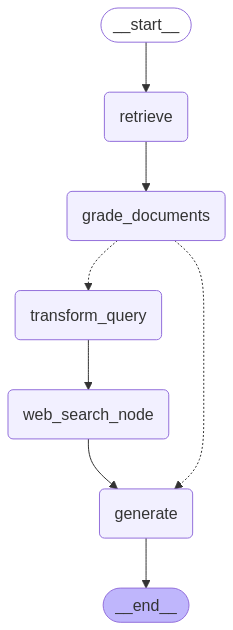

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass